# Relay Control

## Relay Control for the Temperature Control Lab

Relay control is perhaps the simplest form of feedback control that comes to mind for controlling common heaters. This is the on/off control familiar from home thermostats, air conditioners, and other devices where the manipulated variable is in either an "on" state or an "off" state.

The following code implements relay control for temperature T1 on the Temperature Control Lab. At each time step $t_k$, the value of 

$$
\begin{align}
U_{k} & = \begin{cases} 
    U^{max} &\text{if $T_k \leq T^{SP}_k$}\\
    U^{min} & \text{if $T_k \geq T^{SP}_k$}
    \end{cases}
\end{align}
$$

where $ 0\% \leq U_{k} \leq 100\%$ refers to percentage of the maximum heater power, $T_k$ is the measured temperature at time $t_k$, and $T^{SP}_k$ is the temperature setpoint at time $t_k$. Typically $U^{min}$ and $U^{max}$ will be set to 0% and 100%, respectively, but other choices are possible.

Relay control can be implemented as a single line of code in the standard clock-driven loop of the Temperature Control Lab.

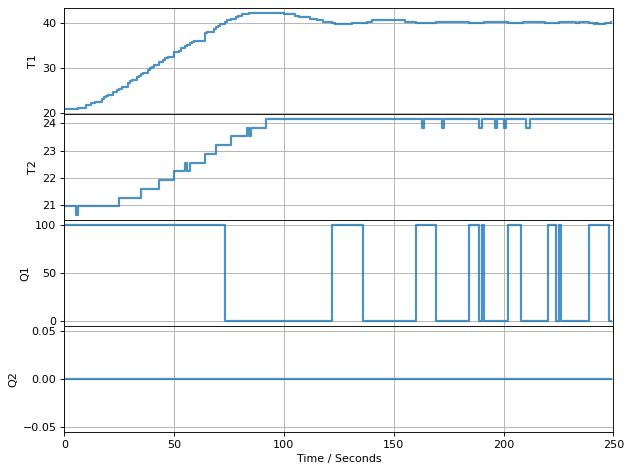

TCLab Model disconnected successfully.


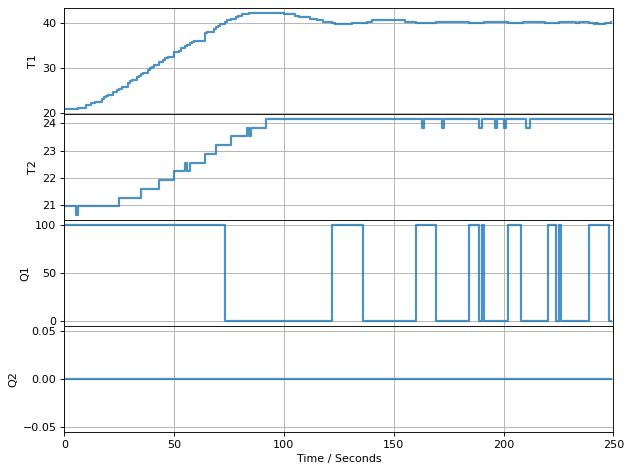

In [1]:
from tclab import TCLab, clock, Historian, Plotter, setup
import matplotlib.pyplot as plt

# Important notes:
# connected=False means we use a digital twin instead of connecting to a real device
# speedup=20 speeds up the simulation by a factor of 20
TCLab = setup(connected=False, speedup=20)

# control parameters
U_min = 0
U_max = 100
T_SP = 40

# time horizon and time step
t_final = 250
t_step = 1

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final, t_step):
        T1 = lab.T1                             # measure temperature
        U1 = U_max if lab.T1 < T_SP else U_min  # compute manipulated variable
        lab.Q1(U1)                              # adjust power
        p.update(t)                             # log results

plt.show()

## Relay Control with Deadzone (Hysteresis) or Deadtime

One of the issues with simple relay control is the potential for 'chattering' where the manipulated variable (in this case heater power) exhibits periods of rapid on-and-off switching. This can be caused by systems that are highly response to control inputs, or where sensor measurements carry significant noise.

There are several simple and highly effective solutions to the problem of chattering.

* **Deadzone** (also called hysteresis). The manipulated variable is switched on or off only after the process variable has moved past the setpoint by a specified amount $d$.
* **Deadtime** Following an on-or-off transition in the manipulated variable, no further transition is allowed for a specified period of time called the deadtime.


The control algorithm for relay control with a deadzone extending $d$ above and below the setpoint, a closed form is given by

$$
\begin{align}
U_{k} & = \begin{cases} 
    U^{max} &\text{if $T_k \leq T^{SP}_k$} - d\\
    U^{min} & \text{if $T_k \geq T^{SP}_k$} + d\\
    U_{k-1} & \text{ otherwise}
    \end{cases}
\end{align}
$$

where $d$ is the *tolerance* or *hysteresis*. 

For home heating systems a typical value is in the range of 0.5 to 1 degree F. This image shows how hystersis was adjusted on a typical home thermostat in common usage in the late 20th century.

<a title="By Vincent de Groot - http://www.videgro.net (Own work) [GFDL (http://www.gnu.org/copyleft/fdl.html), CC-BY-SA-3.0 (http://creativecommons.org/licenses/by-sa/3.0/) or CC BY 2.5 (http://creativecommons.org/licenses/by/2.5)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3AHoneywell_thermostat_open.jpg"><img width="512" alt="Honeywell thermostat open" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Honeywell_thermostat_open.jpg/512px-Honeywell_thermostat_open.jpg"/></a>

The furnance is turned on for temperatures below the range 

$$
\begin{align}
T^{SP} - d \leq T \leq T^{SP} + d
\end{align}
$$

and is turned for temperatures above the range. Within the range, however, the furnance may be on or off depending on what happened at the last decision point.

The following code implements relay control with hystersis. 

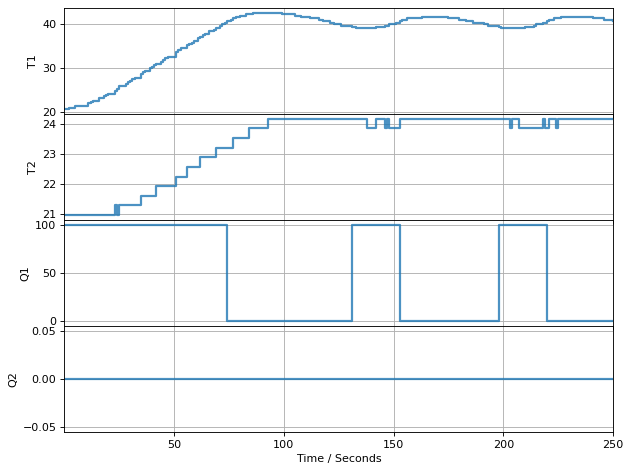

TCLab Model disconnected successfully.


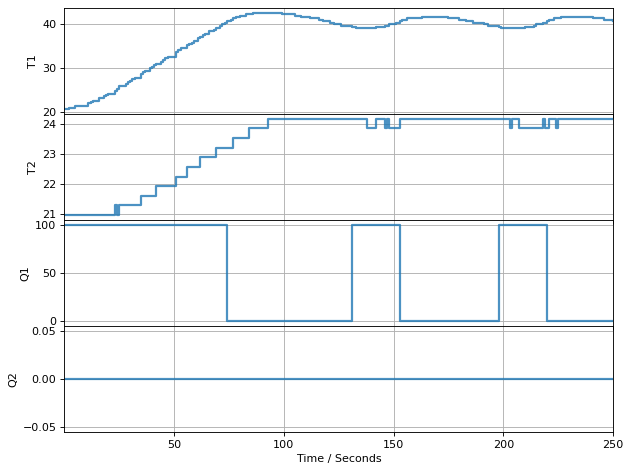

In [2]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
U_min = 0
U_max = 100
T_SP = 40
d = 0.5

# time horizon and time step
t_final = 250
t_step = 1

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    U1 = U_min
    for t in clock(t_final, t_step):
        T1 = lab.T1
        if T1 <= T_SP - d:
            U1 = U_max
        elif T1 >= T_SP + d:
            U1 = U_min
        lab.Q1(U1)
        p.update(t)

plt.show()      

## Numeric Simulation

A key concept of this class is model-based design. For several control architetures, we will augment of mathematical model for the TCLab with a control law. This will then allow use to analyze the dynamics of the closed loop system.

Recall, we can model the TCLab as a linear time-invarient (LTI) system,

$$\begin{align*}
\mathbf{\dot{x}} &= \mathbf{A} \mathbf{x}(t) + \mathbf{B} \mathbf{u}(t)~, \\
\mathbf{y} &= \mathbf{C} \mathbf{x} + \mathbf{D} \mathbf{u}~,
\end{align*}
$$

which has an [analytic solution](../2/Spring-Mass-Damper.ipynb):

\begin{equation*}
\mathbf{x}(t) = \mathbf{\Phi}(t) \mathbf{x}(0) + \int_{0}^{t}\mathbf{\Phi}(t - \tau) \mathbf{B} \mathbf{u}(\tau) d \tau
\end{equation*}

where

\begin{equation*}
\mathbf{\Phi}(t) = e^{-\mathbf{A}t} = \left( \mathbf{I} + \mathbf{A} t + \frac{\mathbf{A}^2 t^2}{2!} + ... + \frac{\mathbf{A}^k t^k}{k!} + ...\right)
\end{equation*}

With some linear algebra, we can convert this continous dynamical system into a discrete dynamical system:

\begin{equation*}
\mathbf{x}_{k+1} = \mathbf{A}_d \mathbf{x}_{k} + \mathbf{B}_d \mathbf{u}_{k}, \qquad y_{k} = \mathbf{C}_d \mathbf{x}_d + \mathbf{D}_d \mathbf{u}_k
\end{equation*}

Once we have converted the dynamical system, we can numerically integrate it using a `for` loop.

If you are curious about how this conversion works, please see [supplemental reference materials](https://users.wpi.edu/~zli11/teaching/rbe595_2017/LectureSlide_PDF/discretization.pdf). Instead, we will just use functionality from the `scipy.signals` package.

Recall the [TCLab state space model](../2/Second-Order.ipynb):

\begin{align*}
\mathbf{A} = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p}\end{bmatrix},
\quad
\mathbf{B} = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}, 
\quad
\mathbf{C} = \begin{bmatrix}0 & 1 \end{bmatrix},
\quad
\mathbf{D} = \begin{bmatrix} 0 \end{bmatrix}
\end{align*}

We can simulate this system using `lsim` as show in [](../2/Spring-Mass-Damper.ipynb).


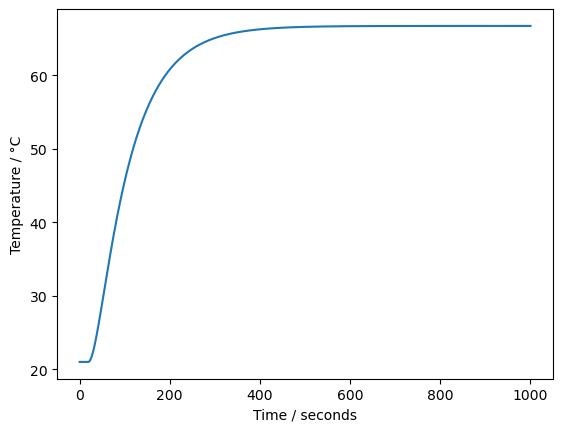

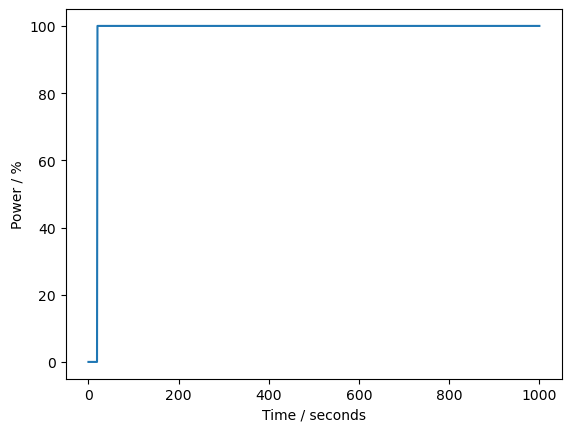

In [3]:
# Define TCLab model parameters
# (adjust as you see fit)
Ua = 0.07
Ub = 0.04
CpH = 4
CpS = 1
alpha = 0.00016
P1 = 200
T_amb = 21

import numpy as np

A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
B = np.array([[alpha*P1/CpH], [0]])
C = np.array([[0, 1]])
D = np.array([[0]])

from scipy.signal import StateSpace, lsim

# Define the state-space model
sys = StateSpace(A, B, C, D)

# Define the time points for the simulation
t = np.linspace(0, 1000, 1001)

# Define the step input
u = np.zeros(len(t))

# Step up to 100 at t = 20
u[20:] = 100

# Simulate the model
t, y, x = lsim(sys, u, t)

# Plot the results
plt.plot(t, y + T_amb)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.show()

plt.plot(t, u)
plt.xlabel('Time / seconds')
plt.ylabel('Power / %')
plt.show()


We can also simulate by converting to a discrete dynamical system using a timestep of 1 second:

In [4]:
from scipy.signal import cont2discrete

Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), dt=1, method='zoh')

print("Ad = \n", Ad)
print("Bd = \n", Bd)
print("Cd = \n", Cd)
print("Dd = \n", Dd)

Ad = 
 [[0.97306846 0.00966884]
 [0.03867536 0.96098241]]
Bd = 
 [[0.00789152]
 [0.00015645]]
Cd = 
 [[0 1]]
Dd = 
 [[0]]


Next, let's numerically integrate the discrete system using a loop and the difference equation.

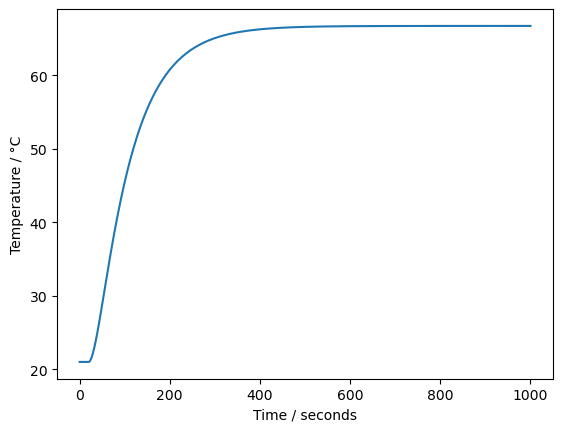

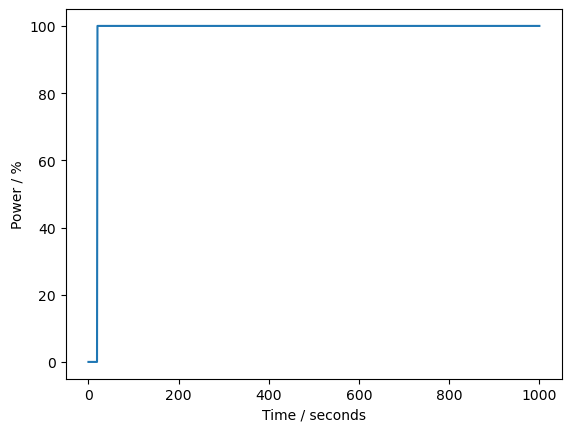

In [5]:
n = len(t)
x = np.zeros((n, 2))
y = np.zeros(n)

# Loop over the timesteps
for i in range(1,len(t)):
    # Update the state
    ''' # Here is one way to do it
    # Why the np.atleast_2d? The state is a 1D array, but the matrix multiplication requires a column vector
    # Why the np.reshape? The result of the matrix multiplication is a 2D array (column vector), but the state
    # is a 1D array (row vector). We need to convert the result back to a 1D array.
    # x[i,:] = np.reshape(Ad @ np.atleast_2d(x[i-1,:]).T + Bd * u[i-1],2)
    '''

    # Here is another way to do it
    # In the Ad @ x[i-1,:] operation, x[i-1,:] is a 1D array.
    # Numpy will automatically convert it to a 2D array (column vector) for the matrix multiplication.
    # In the Bd.T * u[i-1] operation, u[i-1] is a scalar. The .T is needed to convert Bd from a column
    # vector to a row vector. This is because we want to store the result in a row vector, x[i,:].
    x[i,:] = Ad @ x[i-1,:] + Bd.T * u[i-1]

    ''' # Here is one way to do it
    # Compute the output (measurement)
    # Why the np.atleast_2d? The state is a 1D array, but the matrix multiplication requires a column vector
    # Why the np.reshape? The result of the matrix multiplication is a 2D array (column vector), but the state
    # is a 1D array (row vector). We need to convert the result back to a 1D array.
    # Why the [0]? We need to conver the 1D array back to a scalar.
    # y[i] = np.reshape(Cd @ np.atleast_2d(x[i]).T + Dd * u[i],1)[0]
    '''

    # Compute the output (measurement)
    # Here is another way to do it
    # The [0,0] is needed to convert the 2D array (with one element) to a scalar
    y[i] = (Cd @ x[i] + Dd * u[i])[0,0]
    
plt.plot(t, y + T_amb)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.show()

plt.plot(t, u)
plt.xlabel('Time / seconds')
plt.ylabel('Power / %')
plt.show()

Finally, we can implement the relay controller simulation.

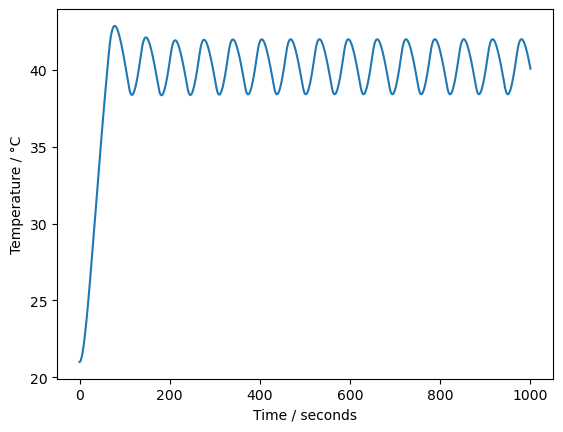

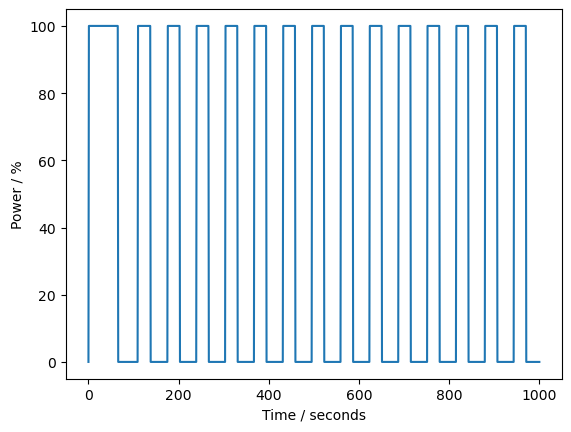

In [6]:
set_point = 40 # set point in degC
d = 1 # deadband

n = len(t)
x = np.zeros((n, 2))
y = np.zeros(n)
u = np.zeros(n)

# Loop over the timesteps
for i in range(1,len(t)):

    # Compute the control action
    if y[i-1] <= (set_point - T_amb) - d:
        # If the temperature is below the set point minus half the deadband, turn on the heater
        u[i] = 100
    elif y[i-1] >= (set_point - T_amb) + d:
        # If the temperature is above the set point plus half the deadband, turn off the heater
        u[i] = 0
    else:
        # Otherwise, keep the heater at the same level
        u[i] = u[i-1]

    # Update the state
    x[i,:] = Ad @ x[i-1] + Bd.T * u[i]

    # Compute the output (measurement)
    y[i] = (Cd @ x[i] + Dd.T * u[i])[0,0]

plt.plot(t, y + T_amb)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.show()

plt.plot(t, u)
plt.xlabel('Time / seconds')
plt.ylabel('Power / %')
plt.show()

## Study Questions

**Q1:** Examining the closed-loop responses, it's obvious that the heater is oversized for the purpose of control at 40 deg C.  Try other values for $Q^{\max}$ to see if you can improve closed-loop performance.

**Q2:** What is the effect of sample time on control performance? What happens if you make the controller sample time longer?

**Q3:** In a new cell, create a modification of the script to include a change in setpoint from 40 deg C to 50 deg C at the 300 second mark. Run the experiment for at least 10 minutes to see the full effect.

**Q4:** For a relay control with deadzone (also called hysteresis), try to sketch a graph of the manipulated variable $Q$ as a function of the process variable $T$. Assume the setpoint is 50 and $d = 3$. Can you draw a unique function? Why not?